In [6]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter1d
import h5py
import copy
import os
import shlex
import torch

from torch.utils.data import DataLoader
from BasisConvolution.util.hyperparameters import defaultHyperParameters, parseHyperParameters, finalizeHyperParameters
from BasisConvolution.util.dataPlotting import getFileCount, getPreparePlotFunction, getUpdatePlotFunction
from BasisConvolution.util.arguments import parser
from BasisConvolution.sph.sphOps import sphOperationStates
from BasisConvolution.util.dataloader import datasetLoader, processFolder#, DataLoader
from BasisConvolution.util.augment import loadAugmentedFrame
from BasisConvolution.util.hyperparameters import make_hash, toPandaDict
from BasisConvolution.util.network import buildModel, runInference
from BasisConvolution.util.augment import augmentState, loadAugmentedBatch
from BasisConvolution.util.plotting import prepVisualizationState, visualizeParticleQuantity


In [2]:
hyperParameterDict = defaultHyperParameters()

hyperParameterDict['batch_size'] = 1
hyperParameterDict['maxRollOut'] = 0

hyperParameterDict['device'] = 'cpu'

hyperParameterDict['augmentAngle'] = False
hyperParameterDict['augmentJitter'] = False

Dropdown(description='File:', layout=Layout(width='initial'), options=('dataset/out_perlin_09771992_2023-10-17…

IntSlider(value=0, description='Slider:', max=2046)

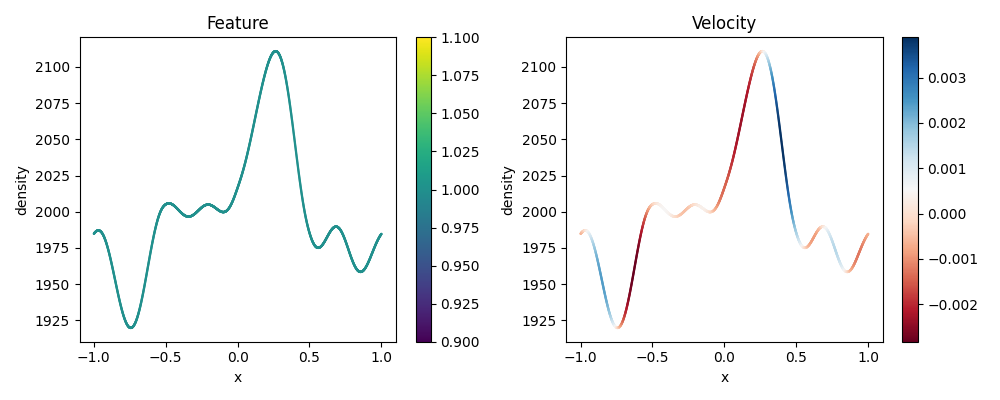

In [3]:
datasetPath = 'dataset'

train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))

plotState = getPreparePlotFunction(train_ds.fileFormat)(train_ds, hyperParameterDict)
updateFn = getUpdatePlotFunction(train_ds.fileFormat)

dropdown = widgets.Dropdown(options=train_ds.fileNames, description='File:', layout={'width': 'initial'})
slider = widgets.IntSlider(min=0, max=getFileCount(train_ds.fileNames[0]), value=0, description='Slider:')

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        slider.max = getFileCount(change['new'])
        if slider.value > slider.max:
            slider.value = 0
        # print(change['new'], slider.value)
        updateFn(plotState, train_ds, hyperParameterDict, [change['new'], slider.value, None, None, None])

def on_change_slider(change):
    if change['type'] == 'change' and change['name'] == 'value':   
        # print(change['new'])
        updateFn(plotState, train_ds, hyperParameterDict, [dropdown.value, change['new'], None, None, None])

dropdown.observe(on_change)
slider.observe(on_change_slider)

display(dropdown)
display(slider)

In [7]:
database = pd.DataFrame()

models = []

t = None
basisFunctions = ['ffourier', 'linear', 'ffourier_even', 'ffourier_odd', 'chebyshev']
for basisFunction in basisFunctions:
    # for basisTerms in [2,4,8]:
    for basisTerms in [4]:
        for windowFunction in ['None']:
            # print('Training for ', basisFunction, basisTerms, windowFunction)
            # args = parser.parse_args(shlex.split(f'--fluidFeatures attribute:a --groundTruth compute[rho]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))
            args = parser.parse_args(shlex.split(f'--fluidFeatures constant:1 --boundaryFeatures constant:1 --groundTruth compute[rho]:constant:1/constant:rho0 --basisFunctions {basisFunction} --basisTerms {basisTerms} --windowFunction {windowFunction} --maxUnroll 0 --frameDistance 0 --epochs 1'))

            hyperParameterDict = parseHyperParameters(args, None)
            hyperParameterDict['device'] = 'cuda'
            hyperParameterDict['iterations'] = 2**10
            hyperParameterDict['batchSize'] = 4
            hyperParameterDict['boundary'] = False
            
            train_ds = datasetLoader(processFolder(hyperParameterDict, datasetPath))
            # print(len(train_ds))
            train_loader = DataLoader(train_ds, shuffle=True, batch_size = hyperParameterDict['batchSize']).batch_sampler
            train_iter = iter(train_loader)

            finalizeHyperParameters(hyperParameterDict, train_ds)

            if t is None:
                t = tqdm(range(hyperParameterDict['totalIterations']))
            t.reset( hyperParameterDict['totalIterations'])
            # t.n =
            t.set_description(f'{basisFunction} - {basisTerms} - {windowFunction}')

# print(hyperParameterDict['progressLabel'])

            model, optimizer, scheduler = buildModel(hyperParameterDict, verbose = False)

            model = model.train()

            iterLosses = []
            iterPSNRs = []
            bdatas = []
            # bdata = next(train_iter)
            for i in (range(hyperParameterDict['totalIterations'])):
                try:
                    bdata = next(train_iter)
                except StopIteration:
                    train_iter = iter(train_loader)
                    bdata = next(train_iter)
                bdatas.append(bdata)
                # print(bdata)
                configs, attributes, currentStates, priorStates, trajectoryStates = loadAugmentedBatch(bdata, train_ds, hyperParameterDict)
                # config, attributes, currentState, priorState, trajectoryStates = loadAugmentedFrame(bdata[0], train_ds, hyperParameterDict)

                optimizer.zero_grad()
                predictions = runInference(currentStates, configs, model, verbose = False)
                # print(predictions)
                gts = [traj[0]['fluid']['target'] for traj in trajectoryStates]

                losses = [torch.nn.functional.mse_loss(prediction, gt) for prediction, gt in zip(predictions, gts)]
                
                psnrs= [20 * torch.log10(gt.abs().max()) - 10 * torch.log10(loss) for gt, loss in zip(gts, losses)]
                loss = torch.stack(losses).mean()
                loss.backward()
                psnr = torch.stack(psnrs).mean()
                iterLosses.append([l.item() for l in losses])
                iterPSNRs.append([p.item() for p in psnrs])
                optimizer.step()
                t.set_description(f'{bdata} - {hyperParameterDict["progressLabel"]} - Loss: {loss.item():.4e}, PSNR: {psnr.item():.2f}')
                t.update()
                t.refresh()
            dataFrame = pd.DataFrame([toPandaDict(hyperParameterDict)] * len(bdatas))

            dataFrame['batches'] = bdatas
            for b in range(len(bdata)):
                dataFrame['losses_{}'.format(b)] = [iterLosses[i][b] for i in range(len(bdatas))]
                dataFrame['psnrs_{}'.format(b)] = [iterPSNRs[i][b] for i in range(len(bdatas))]

            dataFrame['losses'] = [np.mean(iterLosses[i]) for i in range(len(bdatas))]
            dataFrame['psnrs'] = [np.mean(iterPSNRs[i]) for i in range(len(bdatas))]
            dataFrame['iteration'] = np.arange(len(bdatas))

            database = pd.concat([database, dataFrame], ignore_index = True)
            models.append(model)

            # break
        # break
    # break

/home/winchenbach/anaconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')


  0%|          | 0/1024 [00:00<?, ?it/s]

/home/winchenbach/anaconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')
/home/winchenbach/anaconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')
/home/winchenbach/anaconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundary data requested but not available. Disabling boundary data.
  warnings.warn('Boundary data requested but not available. Disabling boundary data.')
/home/winchenbach/anaconda3/envs/torch_sfbc/lib/python3.11/site-packages/BasisConvolution/util/hyperparameters.py:517: UserWarning: Boundar

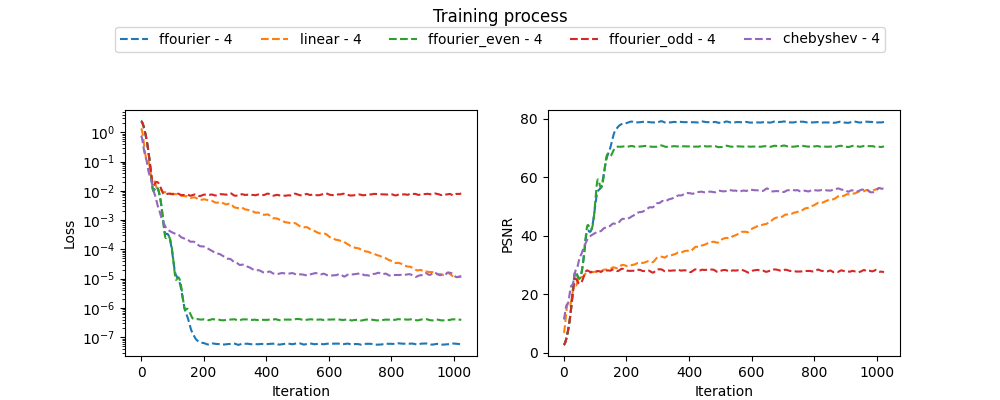

In [8]:
basisTerms = database['basisTerms'].unique()
basisFunctions = database['basisFunctions'].unique()

hues = sns.color_palette(n_colors = len(basisFunctions))
linestyles = ['--', '-', ':', '-.']

fig, axis = plt.subplots(1,2, figsize = (10,4), sharey = False, squeeze= False)

for i, basisFunction in enumerate(basisFunctions):
    for j, basisTerm in enumerate(basisTerms):
        subDatabase = database[(database['basisFunctions'] == basisFunction) & (database['basisTerms'] == basisTerm)]
        # subDatabase = subDatabase[subDatabase['dimension'] == 3]

        iters = subDatabase['iteration']
        losses = subDatabase['losses']
        psnrs = subDatabase['psnrs']

        losses = gaussian_filter1d(losses, sigma = 5)
        psnrs = gaussian_filter1d(psnrs, sigma = 5)

        axis[0,0].plot(iters, losses, label = f'{basisFunction} - {basisTerm}', color = hues[i], ls = linestyles[j % len(linestyles)])
        axis[0,1].plot(iters, psnrs, label = f'{basisFunction} - {basisTerm}', color = hues[i], ls = linestyles[j % len(linestyles)])

axis[0,0].set_yscale('log')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')
# axis[0,0].legend(ncol = 2)

axis[0,1].set_xlabel('Iteration')
axis[0,1].set_ylabel('PSNR')

handles, labels = axis[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol = 5,bbox_to_anchor=(0.5, 0.95))

fig.suptitle('Training process')
fig.subplots_adjust(top = 0.725)
# fig.bbox_inches = 'tight'

# fig.tight_layout()